In [1]:
import csv
import re
import numpy
import scipy.stats 
import matplotlib.pyplot as plt
%matplotlib inline

# Model checking - Ride companies

In this notebook we perform model checking on the ride companies problem from Q2. The original model is the one proposed as the solution to Q2, with:

$$\log{tau} \sim Cauchy(0, 5)$$

$$\log{eta} \sim Normal(mu, tau)$$

$$y \sim Gamma(Observations, Observations / eta)$$

The modified model we propose is simply by changing the original model's prior on tau, to:

$$ \log{tau} \sim Normal(0, 2)$$

## Data  

In [31]:
DATA = "data.csv"
RESULTS = [
    ["GammaCauchyPrior", "GammaCauchyPrior.csv"],
    ["NormalPrior", "NormalPrior.csv"]
]

In [32]:
avg_time = []
count = []
with open(DATA) as f:
    rdr = csv.reader(f)
    next(rdr)
    for rec in rdr:
        count.append(float(rec[1]))
        avg_time.append(float(rec[2]))

In [33]:
count, avg_time

([26.0, 17.0, 11.0, 5.0, 3.0], [7.8, 14.4, 12.0, 20.4, 6.5])

In [34]:
def posterior(result):
    """returns array of samples from the posterior"""
    samples = []
    atmean = None
    with open(result) as f:
        rdr = csv.reader(f)
        next(rdr)
        for rec in rdr:
            mu, tau, eta1, eta2, eta3, eta4, eta5, logp = float(rec[1]), float(rec[2]), float(rec[3]), float(rec[4]), float(rec[5]), float(rec[6]),float(rec[7]), float(rec[8])
            if rec[0]=="sample":
                samples.append([mu, tau, eta1, eta2, eta3, eta4, eta5, logp])
            elif rec[0]=="mean":
                atmean = [mu, tau, eta1, eta2, eta3, eta4, eta5, logp]
    return numpy.array(samples), atmean

In [35]:
SAMPLES = []
for model, result in RESULTS:
    samples, atmean = posterior(result)
    SAMPLES.append([model, samples, atmean])

## Posterior distrubition

Let's draw the posterior distributions for both models, for mu, tau, and logp

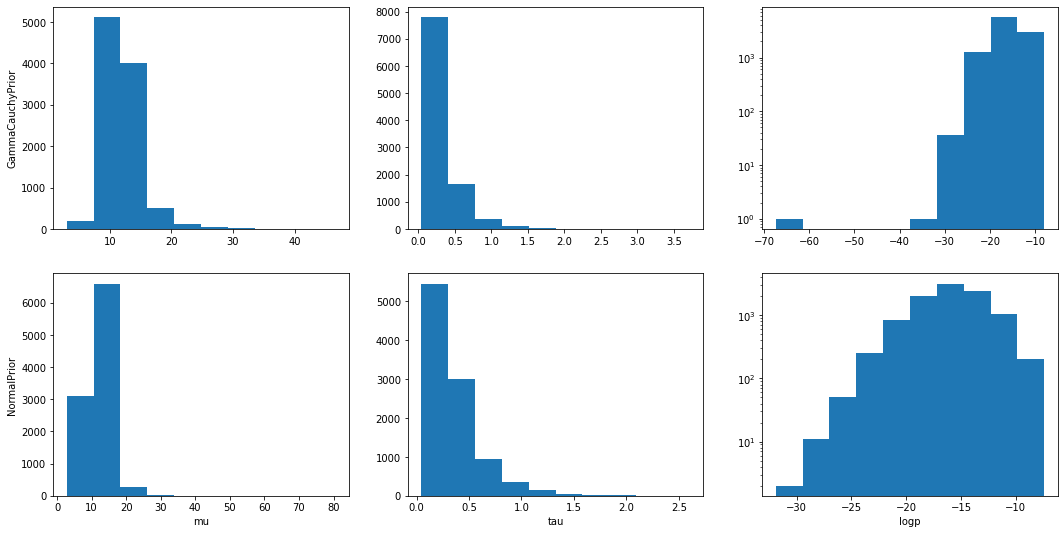

In [36]:
fig, ax = plt.subplots(2,3, figsize=(18, 9))
ax[-1][0].set_xlabel("mu")
ax[-1][1].set_xlabel("tau")
ax[-1][2].set_xlabel("logp")
for i, (model, samples, _) in enumerate(SAMPLES):
    ax[i][0].set_ylabel(model)
    ax[i][2].set_yscale("log")
    ax[i][0].hist(samples[:, 0])
    ax[i][1].hist(samples[:, 1])        
    ax[i][2].hist(samples[:, 7])        

# Model Checking

In this section, we check both models by posterior predictive distibution, using several test quantities: Minimium value, Maximum value, Average, and Standard deviation

In [37]:
def draw_from_gamma(alpha, beta, size=1):
    return scipy.stats.gamma.rvs(alpha, scale=1/beta)

def draw(etas, size=1):
    draws = []
    for index, eta in enumerate(etas):
        draws.append(draw_from_gamma(count[index], count[index]/eta))
    return draws

In [38]:
dataMin, dataMax, dataAvg, dataStd = min(avg_time), max(avg_time), numpy.average(avg_time), numpy.std(avg_time)
print(f"min:\t{dataMin:.3f}\nmax:\t{dataMax:.3f}\navg:\t{dataAvg:.3f}\nstd:\t{dataStd:.3f}")

min:	6.500
max:	20.400
avg:	12.220
std:	4.979


In [39]:
# TODO
def simulate(samples, nobs=1):
    simulation = []
    for iobs in range(nobs):
        i = numpy.random.randint(len(samples))
        etas = samples[i,2:7]
        simulation.append(draw(etas))
    return numpy.array(simulation)

In [40]:
simulate(samples)

array([[10.71999252, 15.46008439,  7.36006103,  4.44521243,  7.57239893]])

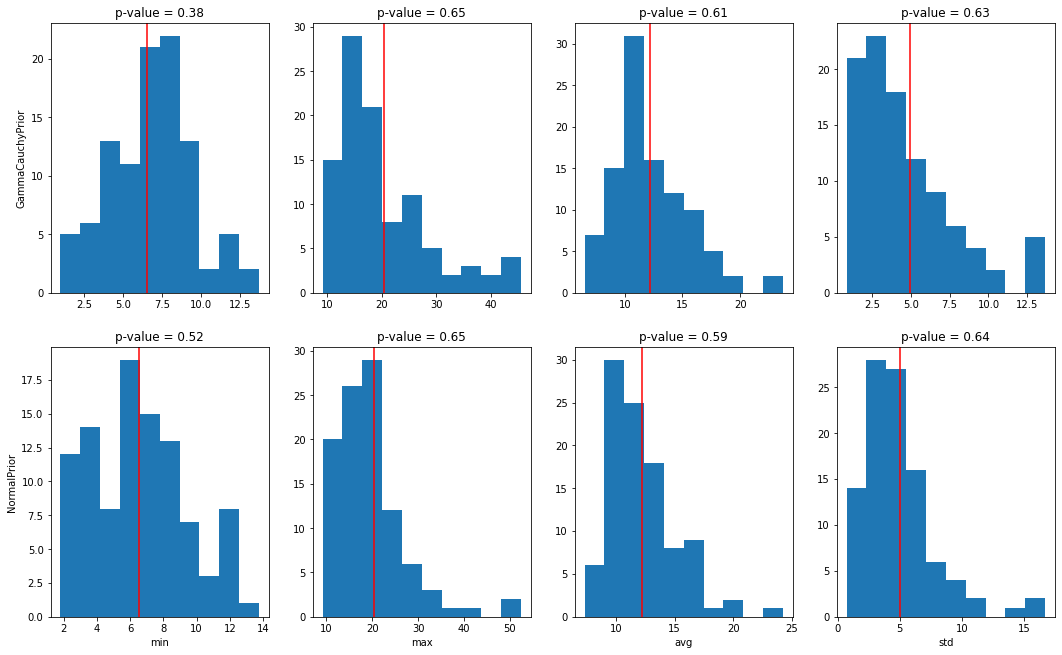

In [41]:
NSIM = 100
fig, ax = plt.subplots(2, 4, figsize=(18, 6))
fig.subplots_adjust(top=1.5)
ax[-1][0].set_xlabel("min")
ax[-1][1].set_xlabel("max")
ax[-1][2].set_xlabel("avg")
ax[-1][3].set_xlabel("std")
for i, (model, samples, _) in enumerate(SAMPLES):
    ax[i][0].set_ylabel(model)
    min_max_median = []
    for j in range(NSIM):
        y = simulate(samples)
        min_max_median.append([y.min(), y.max(), numpy.average(y), numpy.std(y)])
    min_max_median = numpy.array(min_max_median)
    
    # plot data values of test variables as vertical red lines
    ax[i][0].axvline(dataMin, color="red")
    ax[i][1].axvline(dataMax, color="red")
    ax[i][2].axvline(dataAvg, color="red")
    ax[i][3].axvline(dataStd, color="red")
    # plot sampled values of test values as histograms
    for j in range(4):
        ax[i][j].hist(min_max_median[:, j], zorder=-1)
    
    # compute p-values and display them as subplot titles
    ax[i][0].set_title("p-value = {:.2f}".format(
        len(min_max_median[:, 0][min_max_median[:, 0] < dataMin]) /
        len(min_max_median)))
    ax[i][1].set_title("p-value = {:.2f}".format(
        len(min_max_median[:, 1][min_max_median[:, 1] < dataMax]) /
        len(min_max_median)))
    ax[i][2].set_title("p-value = {:.2f}".format(
        len(min_max_median[:, 2][min_max_median[:, 2] < dataAvg]) /
        len(min_max_median)))
    ax[i][3].set_title("p-value = {:.2f}".format(
        len(min_max_median[:, 3][min_max_median[:, 3] < dataStd]) /
        len(min_max_median)))

It can be seen that both model perform pretty well on the chosen test quantities.

Let's try to visualize graphically the distribution of the 5 thetas, compared to the real average waiting time

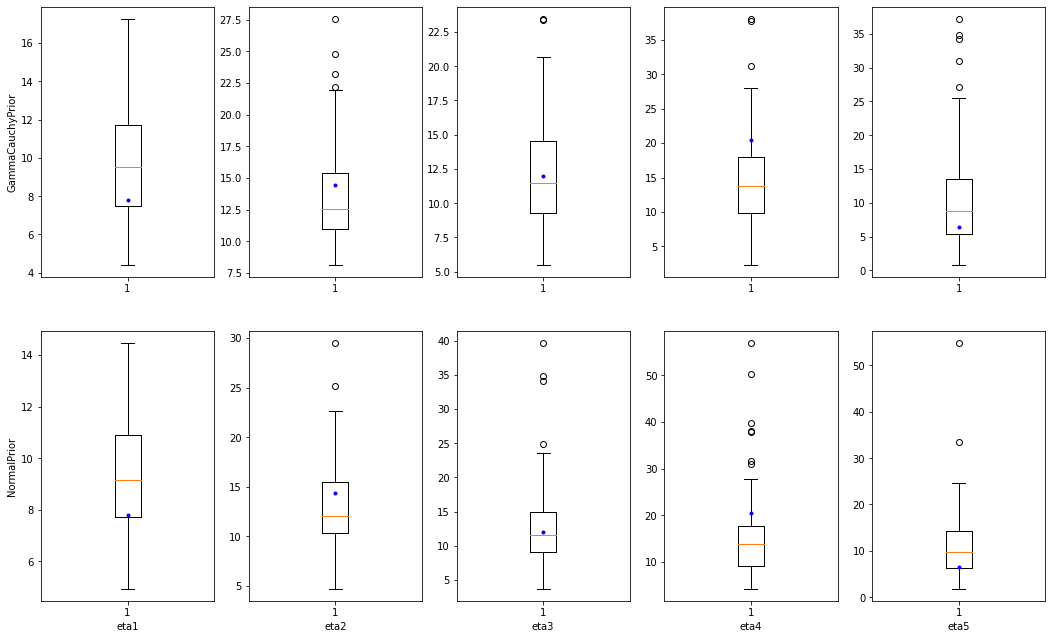

In [42]:
fig, ax = plt.subplots(2, 5, figsize=(18, 6))
fig.subplots_adjust(top=1.5)
ax[-1][0].set_xlabel("eta1")
ax[-1][1].set_xlabel("eta2")
ax[-1][2].set_xlabel("eta3")
ax[-1][3].set_xlabel("eta4")
ax[-1][4].set_xlabel("eta5")

for i, (model, samples, _) in enumerate(SAMPLES):
    ax[i][0].set_ylabel(model)
    min_max_median = []
    y = simulate(samples, nobs=NSIM)
    
    for j in range(5):
        ax[i][j].boxplot(y[:,j])
        ax[i][j].plot(1, avg_time[j], marker='o', markersize=3, color="blue")


# Sensitivity analysis

We will show the effect of the hyperprior on tau in both models

Text(0, 0.5, 'NormalPrior')

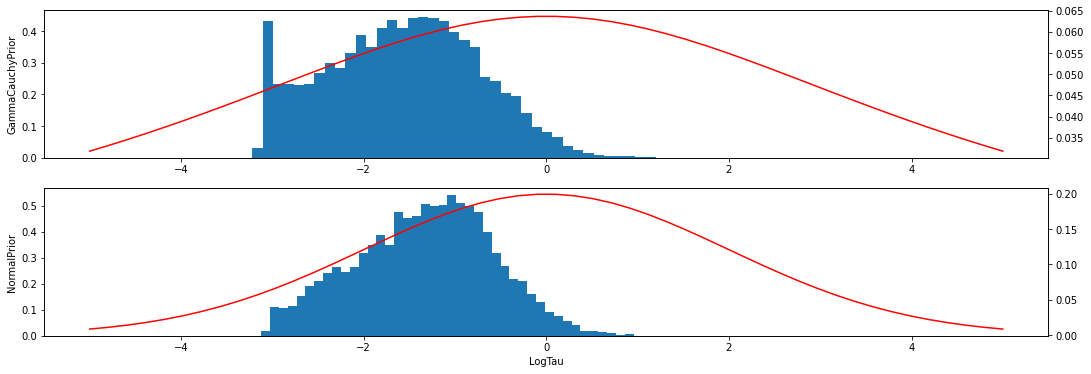

In [44]:
fig, ax = plt.subplots(2, figsize=(18, 6))

_ = ax[0].hist(numpy.log(SAMPLES[0][1][:,1]), density=True, bins='auto')
x = numpy.linspace(-5, 5)
ax1 = ax[0].twinx()
ax1.plot(x, scipy.stats.cauchy(0 ,5).pdf(x), color='r')

_ = ax[1].hist(numpy.log(SAMPLES[1][1][:,1]), density=True, bins='auto')
x = numpy.linspace(-5, 5)
ax2 = ax[1].twinx()
ax2.plot(x, scipy.stats.norm(0 ,2).pdf(x), color='r')
ax[0].set_ylabel("GammaCauchyPrior")
ax[1].set_xlabel("LogTau")
ax[1].set_ylabel("NormalPrior")

We can see that the prior on the hyperprior doesn't affect a lot the $\log{tau}$ value. Now, we will compute the effect of tau on the 5 different etas!

We do that by bucketing tau values into 10 bins, and calculating the average eta value for each bin

In [46]:
theta = SAMPLES[0][1][:, 2:7]
tau = numpy.log(SAMPLES[0][1][:,1])
theta2 = SAMPLES[1][1][:, 2:7]
tau2 = numpy.log(SAMPLES[1][1][:,1])

In [47]:
tau_val, tau_bin = numpy.histogram(tau, 10)
tau2_val, tau2_bin = numpy.histogram(tau2, 10)

thetas_by_tau_bins = numpy.zeros((10,5))
thetas_by_tau2_bins = numpy.zeros((10,5))
for i in range(len(theta)):
    for j, value in enumerate(theta[i]):
        tau_bin_number = numpy.where((tau_bin < tau[i]) == False)[0][0] - 1 if len(numpy.where((tau_bin < tau[i]) == False)[0]) is not 0 else -1
        thetas_by_tau_bins[tau_bin_number][j] += value
        
for i in range(len(theta2)):
    for j, value in enumerate(theta2[i]):
        tau2_bin_number = numpy.where((tau2_bin < tau2[i]) == False)[0][0] - 1 if len(numpy.where((tau2_bin < tau2[i]) == False)[0]) is not 0 else -1
        thetas_by_tau2_bins[tau2_bin_number][j] += value
        
thetas_by_tau_bins /= tau_val.repeat(5).reshape(10,5)
thetas_by_tau2_bins /= tau2_val.repeat(5).reshape(10,5)

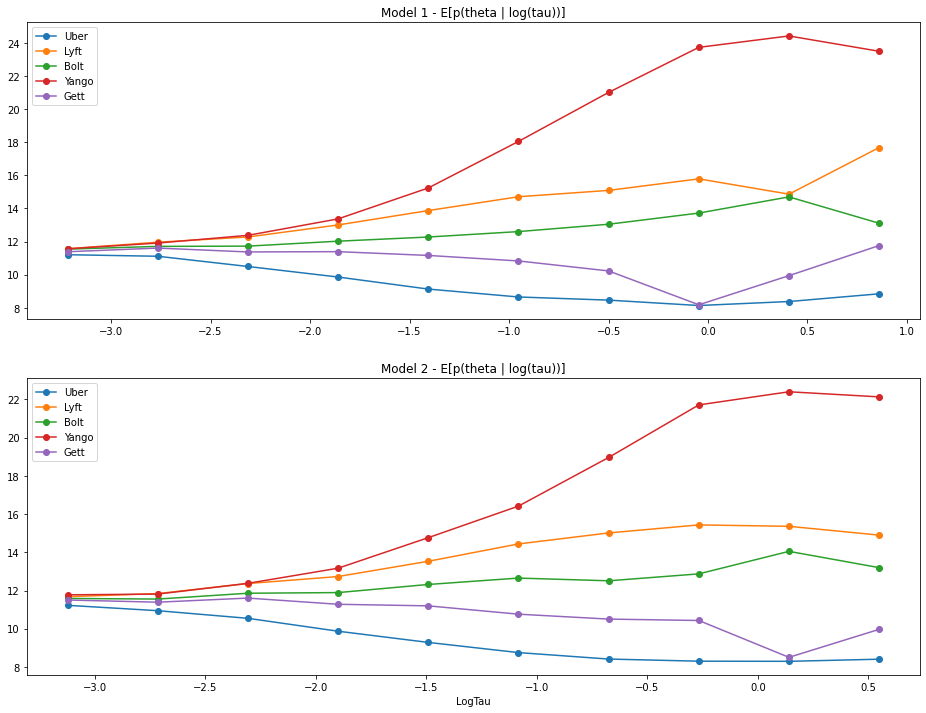

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
companies = ['Uber', 'Lyft', 'Bolt', 'Yango', 'Gett']
ax[0].set_title("Model 1 - E[p(theta | log(tau))]")
ax[1].set_title("Model 2 - E[p(theta | log(tau))]")
ax[1].set_xlabel("LogTau")

for index, val in enumerate(thetas_by_tau_bins.T):
    ax[0].plot(tau_bin[:-1], val, marker='o', label=companies[index])
 
for index, val in enumerate(thetas_by_tau2_bins.T):
    ax[1].plot(tau2_bin[:-1], val, marker='o', label=companies[index])
_ = ax[0].legend()
_ = ax[1].legend()

As it can be seen, $\theta$ are quite sensitive to $\log{\tau}$ value. As it increases, the $\theta$ are getting bigger differences between them, in both models. This is reasonable result since $\log{\theta} \sim Normal(\log{\mu}, \tau)$, thus when tau is bigger there's a bigger variance in the normal dist.

In both models, Uber is the recommended company to book a taxi from.

### Evaluation

Reminder: Our alternative model was created by changing the prior on tau such that $\log{\tau} \sim Normal(0, 2)$ instead of $\log{\tau} \sim Cauchy(0, 5)$ in the original model.

We compute the Loo-CV LPPD for both models

In [49]:
def read_cv(result):
    """returns array of samples from the posterior"""
    samples = []
    atmean = None
    with open(result) as f:
        rdr = csv.reader(f)
        next(rdr)
        for rec in rdr:
            if rec[0]=="sample":
                mu, sigma, eta1, eta2, eta3, eta4, logp = float(rec[1]), float(rec[2]), float(rec[3]), float(rec[4]), float(rec[5]), float(rec[6]),float(rec[7]) 
                samples.append([mu, sigma, eta1, eta2, eta3, eta4, logp])
    return numpy.array(samples)

In [50]:
CV_GAMMA_CAUCHY= [
    ["CV1", "GammaCauchyPrior_cv1.csv"],
    ["CV2", "GammaCauchyPrior_cv2.csv"],
    ["CV3", "GammaCauchyPrior_cv3.csv"],
    ["CV4", "GammaCauchyPrior_cv4.csv"],
    ["CV5", "GammaCauchyPrior_cv5.csv"],
]
CV_NORMAL = [
    ["CV1", "NormalPrior_cv1.csv"],
    ["CV2", "NormalPrior_cv2.csv"],
    ["CV3", "NormalPrior_cv3.csv"],
    ["CV4", "NormalPrior_cv4.csv"],
    ["CV5", "NormalPrior_cv5.csv"],
]
cv_model1 = []
cv_model2 = []
for cv, result in CV_GAMMA_CAUCHY:
    samples = read_cv(result)
    cv_model1.append([cv, samples])
    
for cv, result in CV_NORMAL:
    samples = read_cv(result)
    cv_model2.append([cv, samples])

In [51]:
avg_time, count

([7.8, 14.4, 12.0, 20.4, 6.5], [26.0, 17.0, 11.0, 5.0, 3.0])

In [52]:
model_1_res = 0
for i in range(len(avg_time)):
    sim_data = cv_model1[i][1]
    samples = sim_data[numpy.random.randint(0, len(sim_data), size=500)]
    ll = 0
    for sample in samples:
        mu = sample[0]
        tau = sample[1]
        
        logEta = numpy.random.normal(numpy.log(mu), tau, 1)
        ll += scipy.stats.gamma.pdf(x=avg_time[i],a=count[i], scale=numpy.exp(logEta)/count[i])
    ll /= len(samples)
    model_1_res += numpy.log(ll)

print("Original model with cauchy prior on tau LOO-CV LPPD:", model_1_res[0])


Original model with cauchy prior on tau LOO-CV LPPD: -16.38796768619654


In [53]:
model_2_res = 0
for i in range(len(avg_time)):
    sim_data = cv_model2[i][1]
    samples = sim_data[numpy.random.randint(0, len(sim_data), size=500)]
    ll = 0
    for sample in samples:
        mu = sample[0]
        tau = sample[1]
        
        logEta = numpy.random.normal(numpy.log(mu), tau, 1)
        ll += scipy.stats.gamma.pdf(x=avg_time[i],a=count[i], scale=numpy.exp(logEta)/count[i])
    ll /= len(samples)
    model_2_res += numpy.log(ll)

print("Modified model with normal prior on tau LOO-CV LPPD:", model_2_res[0])



Modified model with normal prior on tau LOO-CV LPPD: -16.436455427130795
